Number of members : 440
Number of bills : 808
(440, 808)


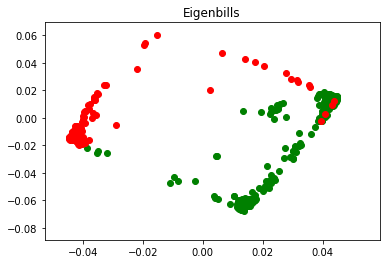

Text(0.5, 1.0, 'Eigenmembers')

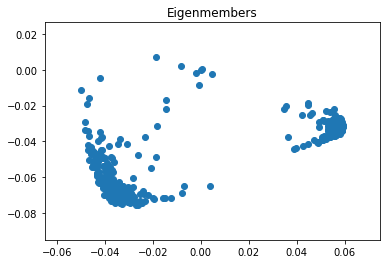

In [18]:
import csv
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

import sys
import math

if len(sys.argv) == 2:
    congress = sys.argv[1]
else:
    congress = 'H115'
congress = 'H116'

data_folder = 'data/'+congress+'/'
output_folder = 'output/raw/'+congress+'/'+congress+'_'
hd_file = 'output/house_details.csv'
trunc = 2

passed_indices = []
failed_indices = []
unknown_indices = []

member_count = -1
member_icpsr = {}
with open(data_folder+congress+'_members.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if not (member_count == -1):
            member_icpsr[row[2]] = member_count
        member_count = member_count + 1
bill_count = -1
bill_roll = {}
with open(data_folder+congress+'_rollcalls.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if bill_count == -1:
            bill_count = bill_count+1
            continue
        if not bill_count == -1:
            bill_roll[row[2]] = bill_count
        if row[14].lower() == 'passed':
            passed_indices.append(int(row[2])-1)
        elif row[14].lower() == 'failed':
            failed_indices.append(int(row[2])-1)
        else:
            unknown_indices.append(int(row[2])-1)
        bill_count = bill_count + 1
print("Number of members : " + str(member_count))
print("Number of bills : " + str(bill_count))

A = np.zeros((member_count, bill_count))
I = np.eye(bill_count)

vote_count = -1
abstention_count = 0
with open(data_folder+congress+'_votes.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if not vote_count == -1:
            if int(row[4]) == 1:
                A[member_icpsr[row[3]]][bill_roll[row[2]]] = 1
            elif int(row[4]) == 6:
                A[member_icpsr[row[3]]][bill_roll[row[2]]] = -1
            else:
                A[member_icpsr[row[3]]][bill_roll[row[2]]] = 0
                if int(row[4]) == 9:
                    abstention_count = abstention_count + 1
        vote_count = vote_count+1

u, s, vh = np.linalg.svd(A)
print(A.shape)

#plt.scatter(vh[0,:], vh[1,:])
plt.scatter(vh[0,passed_indices], vh[1,passed_indices], c='g')
plt.scatter(vh[0,failed_indices], vh[1,failed_indices], c='r')
plt.title('Eigenbills')
plt.show()
#plt.scatter(u[:n_p,0], u[:n_p,1], c='r')
#plt.scatter(u[n_p+1:,0], u[n_p+1:,1], c='b')
plt.scatter(u[:,0], u[:,1])
plt.title('Eigenmembers')


In [2]:
def std_vot_mat(a):
    a_sorted = np.copy(a)
    [u,s,v]=np.linalg.svd(a);
    a1 = 1;
    a2 = 0;
    b1 = 1;
    b2 = 0;
    mem_inds = sorted(range(u.shape[0]), key=lambda k: b1*u[k,0]+b2*u[k,1])
    bill_inds = sorted(range(v.shape[0]), key=lambda k: a1*v[0,k]+a2*v[1,k])
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a_sorted[i,j] = a[mem_inds[i], bill_inds[j]]
    return a_sorted, mem_inds, bill_inds

a_sorted, m_ind, b_ind = std_vot_mat(A)

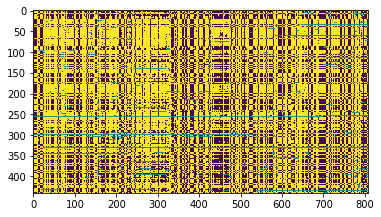

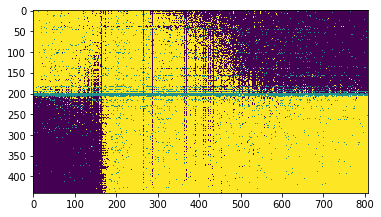

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
'''
mem_inds = sorted(range(len(mem)), key=lambda k: mem[k])
bill_inds = sorted(range(len(bill_params)), key=lambda k: 10*np.exp(bill_params[k][0])+0.1*bill_params[k][1])
a_sorted = np.copy(a)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a_sorted[i,j] = a[mem_inds[i], bill_inds[j]]
plt.imshow(a_sorted)
plt.show()
'''
plt.imshow(A)
plt.show()
plt.imshow(a_sorted)
plt.show()

Number of Tokens collected:
1303
(808, 1303, 1)


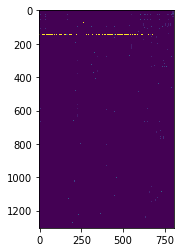

In [4]:
tokens = dict()
bill_details = []
with open(output_folder+'eigenbills.csv') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    for row in csv_reader:
        bill_details.append(row)
        for token in bill_details[-1][-1].split(' '):
            if token.lower() not in tokens:
                tokens[token.lower()] = 1
            else:
                tokens[token.lower()] = tokens[token.lower()]+1

all_b = []
for i in range(len(b_ind)):
    all_b.append(bill_details[b_ind[i]][-1])
                
print('Number of Tokens collected:')
#print(tokens.keys())
print(len(tokens.keys()))

def vectorize(sent_list):
    vec_list = []
    for sent in sent_list:
        vec = np.zeros((len(tokens.keys()),1))
        if len(sent) == 0:
            vec_list.append(vec)
            break
        vec_dict = dict()
        for token in tokens.keys():
            vec_dict[token] = 0
        for token in sent.split(' '):
            vec_dict[token.lower()] = vec_dict[token.lower()]+1
        i = 0
        for token in tokens.keys():
            vec[i] = vec_dict[token]
            i = i + 1
        vec = vec/sum(vec)
        vec_list.append(vec)
    return vec_list

import operator
sorted_tokens = sorted(tokens.items(), key=operator.itemgetter(1), reverse=True)

stopwords = [word[0] for word in sorted_tokens[:5]]
for i in range(len(all_b)):
    #print(all_b[i])
    querywords = all_b[i].split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    all_b[i] = result
    #print(all_b[i])
vectorized = vectorize(all_b)
vectorized = np.array(vectorized)
#print(vectorized)
print(vectorized.shape)
plt.imshow(vectorized[:,:,0].T)
vectorized = vectorized[:,:,0].T

(1303, 808)


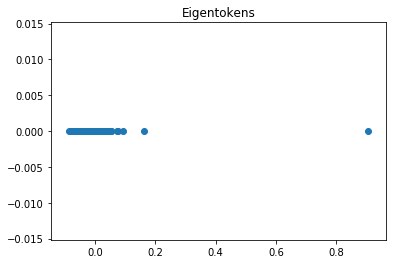

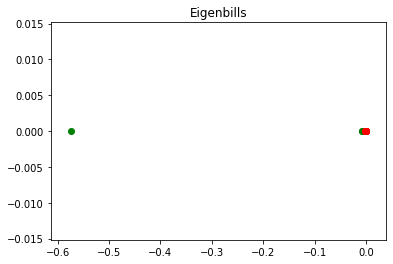

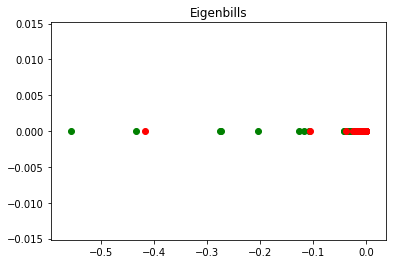

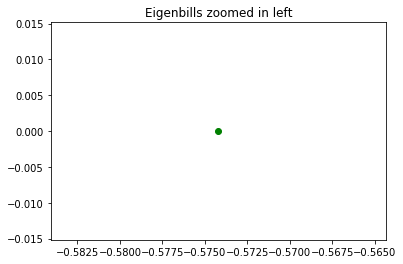

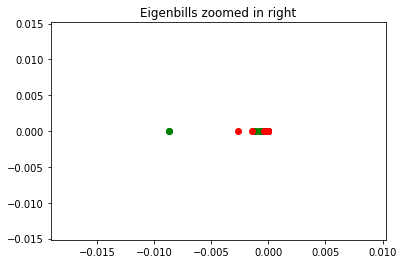

PL: 1
PR: 419
FL: 0
FR: 177


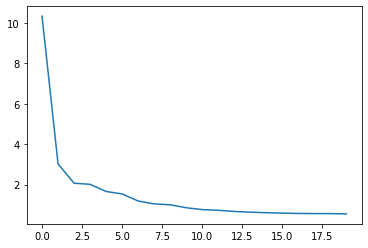

In [31]:
u, s, vh = np.linalg.svd(vectorized)
print(vectorized.shape)

'''
passed_indices = []
failed_indices = []
for i in range(A.shape[1]):
    if np.sum(A[:,i]) > 0:
        passed_indices.append(i)
    else:
        failed_indices.append(i)
'''
#plt.scatter(vh[0,:], vh[1,:])
plt.scatter(vh[:,0],[0 for i in range(vh.shape[0])])
#plt.scatter(vh[0,passed_indices], vh[1,passed_indices], c='g')
#plt.scatter(vh[0,failed_indices], vh[1,failed_indices], c='r')
plt.title('Eigentokens')
plt.show()
#plt.scatter(u[:n_p,0], u[:n_p,1], c='r')
#plt.scatter(u[n_p+1:,0], u[n_p+1:,1], c='b')
#plt.scatter(u[:,0], u[:,1])
plt.scatter(u[passed_indices,0],[0 for i in range(len(passed_indices))],c='g')
plt.scatter(u[failed_indices,0],[0 for i in range(len(failed_indices))],c='r')
plt.title('Eigenbills')
#plt.show()
plt.savefig('Eigen-BT')
plt.show()
plt.scatter(u[passed_indices,1],[0 for i in range(len(passed_indices))],c='g')
plt.scatter(u[failed_indices,1],[0 for i in range(len(failed_indices))],c='r')
plt.title('Eigenbills')
#plt.show()
plt.savefig('Eigen-BT')
plt.show()

u_passed = u[passed_indices,0]
u_failed = u[failed_indices,0]
passed_left = []
passed_right = []
for i in range(len(passed_indices)):
    if u_passed[i] < (min(u[:,0])+max(u[:,0]))/2.0:
        passed_left.append(i)
    else:
        passed_right.append(i)
failed_left = []
failed_right = []
for i in range(len(failed_indices)):
    if u_failed[i] < (min(u[:,0])+max(u[:,0]))/2.0:
        failed_left.append(i)
    else:
        failed_right.append(i)

u_passed_left = u_passed[passed_left]
u_passed_right = u_passed[passed_right]
u_failed_left = u_failed[failed_left]
u_failed_right = u_failed[failed_right]
plt.scatter(u_passed[passed_left],[0 for i in range(len(passed_left))],c='g')
plt.scatter(u_failed[failed_left],[0 for i in range(len(failed_left))],c='r')
plt.title('Eigenbills zoomed in left')
plt.show()
plt.scatter(u_passed[passed_right],[0 for i in range(len(passed_right))],c='g')
plt.scatter(u_failed[failed_right],[0 for i in range(len(failed_right))],c='r')
plt.title('Eigenbills zoomed in right')
plt.show()
print('PL: ' + str(len(passed_left)))
print('PR: ' + str(len(passed_right)))
print('FL: ' + str(len(failed_left)))
print('FR: ' + str(len(failed_right)))

plt.plot(s[:20])
plt.show()
plt.show()